<a href="https://colab.research.google.com/github/Amanparijoshi/cgm-glucose-forecasting-lstm-gru/blob/main/discriptive_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd


file_path = '/content/drive/MyDrive/diabetes/Subject 1_3hr.csv'
df = pd.read_csv(file_path)
print("Column names in Subject 1_3hr.csv:")
print(df.columns.tolist())


Column names in Subject 1_3hr.csv:
['EventDateTime', 'DeviceMode', 'Basal', 'CorrectionDelivered', 'TotalBolusInsulinDelivered', 'FoodDelivered', 'CarbSize', 'CGM']


In [ ]:

#  Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
from google.colab import drive
import os

# Mount Drive

drive.mount('/content/drive')


# ⚙️ Helper Functions

def detect_cols(df):
    """Automatically detect timestamp and CGM column names."""
    dt_col, cgm_col = None, None
    for c in df.columns:
        if "date" in c.lower() or "time" in c.lower():
            dt_col = c
        if "cgm" in c.lower() or "glucose" in c.lower():
            cgm_col = c
    return dt_col, cgm_col

def save_fig(fig, path):
    """Save and close figures safely."""
    fig.tight_layout()
    fig.savefig(path, dpi=200)
    plt.close(fig)

#  Load All Subjects

base_dir = '/content/drive/MyDrive/diabetes/'
subject_files = [f'Subject {i}_3hr.csv' for i in range(1, 26)]
subjects = {}

for file_name in subject_files:
    path = os.path.join(base_dir, file_name)
    try:
        df = pd.read_csv(path)
        df.rename(columns=lambda x: x.strip(), inplace=True)
        dt_col, cgm_col = detect_cols(df)

        if not dt_col or not cgm_col:
            print(f"⚠️ Skipped {file_name}: Could not detect timestamp or CGM column")
            continue

        df[dt_col] = pd.to_datetime(df[dt_col], errors='coerce')
        df = df.dropna(subset=[dt_col, cgm_col])
        df = df.sort_values(dt_col)
        df = df.rename(columns={dt_col: "EventDateTime", cgm_col: "CGM"})
        subjects[file_name] = df

    except Exception as e:
        print(f"⚠️ Skipped {file_name}: {e}")

print(f"✅ Loaded {len(subjects)} subjects successfully.")


# Create Output Folder

output_dir = os.path.join(base_dir, "graphs_output")
os.makedirs(output_dir, exist_ok=True)


#  CGM Time Series (Representative Subjects)

fig = plt.figure(figsize=(10,5))
rep_subjects = list(subjects.keys())[:3]
for s in rep_subjects:
    df = subjects[s]
    plt.plot(df['EventDateTime'], df['CGM'], label=s.split('_')[0])
plt.title("CGM Time Series (Representative Subjects)")
plt.xlabel("Time")
plt.ylabel("Glucose (mg/dL)")
plt.legend()
plt.grid(True)
save_fig(fig, os.path.join(output_dir, "1_CGM_TimeSeries.png"))


# 2Average 24-Hour Profile

group_profiles = []
for s, df in subjects.items():
    df['hour'] = df['EventDateTime'].dt.hour
    avg_profile = df.groupby('hour')['CGM'].mean()
    group_profiles.append(avg_profile)

group_profiles_df = pd.concat(group_profiles, axis=1)
group_mean = group_profiles_df.mean(axis=1)
group_std = group_profiles_df.std(axis=1)

fig = plt.figure(figsize=(10,5))
plt.plot(group_mean.index, group_mean, color='b', label='Mean Glucose')
plt.fill_between(group_mean.index, group_mean - group_std, group_mean + group_std, color='blue', alpha=0.2)
plt.title("Average 24-hour Glucose Profile (All Subjects)")
plt.xlabel("Hour of Day")
plt.ylabel("Glucose (mg/dL)")
plt.legend()
plt.grid(True)
save_fig(fig, os.path.join(output_dir, "2_Avg_24h_Profile.png"))

# 3️⃣ Glucose Variability Metrics

metrics = []
for s, df in subjects.items():
    mean_glucose = df['CGM'].mean()
    std_glucose = df['CGM'].std()
    max_glucose = df['CGM'].max()
    min_glucose = df['CGM'].min()
    cv = std_glucose / mean_glucose * 100
    metrics.append([s, mean_glucose, std_glucose, max_glucose, min_glucose, cv])

metrics_df = pd.DataFrame(metrics, columns=['Subject', 'Mean', 'Std', 'Max', 'Min', 'CV'])

fig = plt.figure(figsize=(10,5))
sns.boxplot(data=metrics_df[['Mean', 'Std', 'CV']])
plt.title("Distribution of Glucose Variability Metrics")
plt.ylabel("Value")
plt.grid(True)
save_fig(fig, os.path.join(output_dir, "3_Variability_Boxplot.png"))


# 4️⃣ Correlation Heatmap

corr = metrics_df[['Mean', 'Std', 'Max', 'Min', 'CV']].corr()
fig = plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Glucose Metrics")
save_fig(fig, os.path.join(output_dir, "4_Correlation_Heatmap.png"))

# 5️⃣ PCA Biplot

X = metrics_df[['Mean', 'Std', 'Max', 'Min', 'CV']]
X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

fig = plt.figure(figsize=(8,6))
plt.scatter(pca_result[:,0], pca_result[:,1], c='royalblue')
for i, subj in enumerate(metrics_df['Subject']):
    plt.text(pca_result[i,0]+0.02, pca_result[i,1]+0.02, subj.split('_')[0], fontsize=8)
plt.title("PCA Biplot: CGM Feature Clustering Across Subjects")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
save_fig(fig, os.path.join(output_dir, "5_PCA_Biplot.png"))

# 6️⃣ DTW Similarity (Advanced)

def dtw_distance(ts1, ts2):
    n, m = len(ts1), len(ts2)
    dtw = np.zeros((n+1, m+1)) + np.inf
    dtw[0, 0] = 0
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(ts1[i-1] - ts2[j-1])
            dtw[i, j] = cost + min(dtw[i-1, j], dtw[i, j-1], dtw[i-1, j-1])
    return dtw[n, m]

series = [subjects[s]['CGM'].values[:100] for s in subjects]
dtw_matrix = np.zeros((len(series), len(series)))

for i in range(len(series)):
    for j in range(i+1, len(series)):
        dist = dtw_distance(series[i], series[j])
        dtw_matrix[i, j] = dtw_matrix[j, i] = dist

fig = plt.figure(figsize=(8,6))
sns.heatmap(dtw_matrix, cmap='viridis')
plt.title("DTW Distance Matrix – Glucose Similarity Between Subjects")
plt.xlabel("Subjects")
plt.ylabel("Subjects")
save_fig(fig, os.path.join(output_dir, "6_DTW_Similarity.png"))

print("✅ All 6 graphs saved successfully to:", output_dir)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Loaded 25 subjects successfully.
✅ All 6 graphs saved successfully to: /content/drive/MyDrive/diabetes/graphs_output


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Loaded Subject 1_3hr.csv
✅ Loaded Subject 2_3hr.csv
✅ Loaded Subject 3_3hr.csv
✅ Loaded Subject 4_3hr.csv
✅ Loaded Subject 5_3hr.csv
✅ Loaded Subject 6_3hr.csv
✅ Loaded Subject 7_3hr.csv
✅ Loaded Subject 8_3hr.csv
✅ Loaded Subject 9_3hr.csv
✅ Loaded Subject 10_3hr.csv
✅ Loaded Subject 11_3hr.csv
✅ Loaded Subject 12_3hr.csv
✅ Loaded Subject 13_3hr.csv
⚠️ Skipped Subject 14_3hr.csv: Missing EventDateTime or CGM
✅ Loaded Subject 15_3hr.csv
✅ Loaded Subject 16_3hr.csv
✅ Loaded Subject 17_3hr.csv
✅ Loaded Subject 18_3hr.csv
✅ Loaded Subject 19_3hr.csv
✅ Loaded Subject 20_3hr.csv
✅ Loaded Subject 21_3hr.csv
✅ Loaded Subject 22_3hr.csv
✅ Loaded Subject 23_3hr.csv
✅ Loaded Subject 24_3hr.csv
✅ Loaded Subject 25_3hr.csv


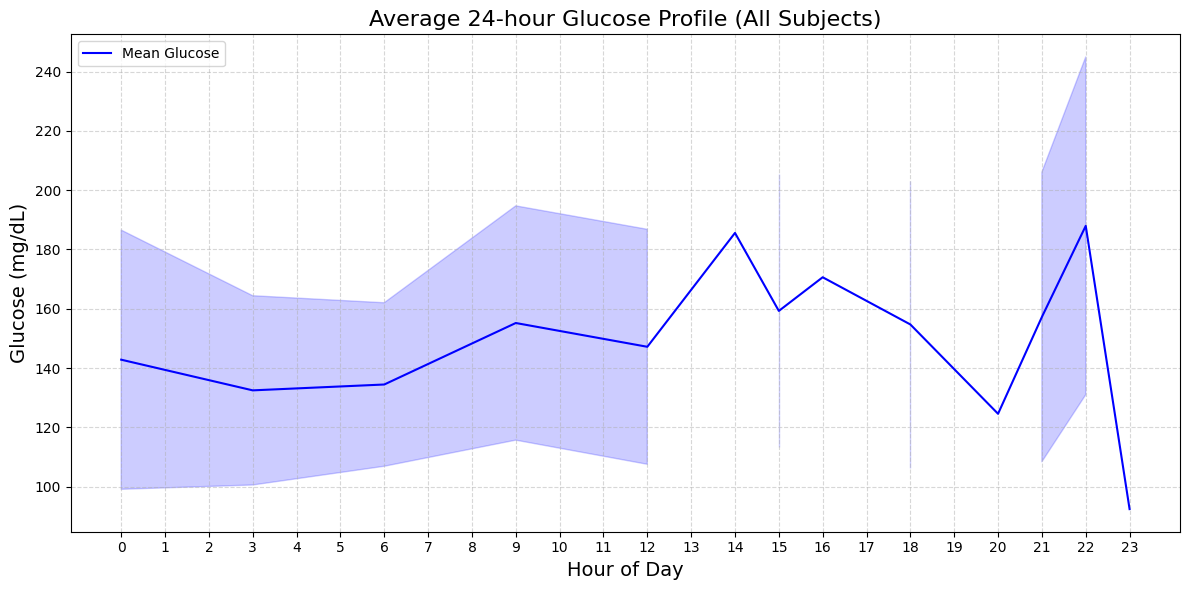


✅ Saved corrected graph to: /content/drive/MyDrive/diabetes/Average_24hr_Profile.png


In [ ]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import drive


# 1) Mount Google Drive

drive.mount('/content/drive')


# 2) Data folder

BASE_DIR = "/content/drive/MyDrive/diabetes"

# Subjects are named: Subject 1_3hr.csv ... Subject 25_3hr.csv
subject_files = [f"Subject {i}_3hr.csv" for i in range(1, 26)]

all_hours = []


# 3) Load each subject properly

for fname in subject_files:
    path = os.path.join(BASE_DIR, fname)

    try:
        df = pd.read_csv(path)
        df.columns = df.columns.str.strip()  # clean column names

        # Must have EventDateTime and CGM
        if "EventDateTime" not in df.columns or "CGM" not in df.columns:
            print(f"⚠️ Skipped {fname}: Missing EventDateTime or CGM")
            continue

        # Convert time
        df["EventDateTime"] = pd.to_datetime(df["EventDateTime"], errors='coerce')
        df = df.dropna(subset=["EventDateTime", "CGM"])

        # Extract hour of day (0–23)
        df["hour"] = df["EventDateTime"].dt.hour

        all_hours.append(df[["hour", "CGM"]])

        print(f"✅ Loaded {fname}")

    except Exception as e:
        print(f"⚠️ Error loading {fname}: {e}")


# 4) Combine all subjects

combined = pd.concat(all_hours, ignore_index=True)

# Compute mean and std for each hour
group_mean = combined.groupby("hour")["CGM"].mean()
group_std  = combined.groupby("hour")["CGM"].std()

#  Sort the index to fix broken zig-zag plot
group_mean = group_mean.sort_index()
group_std  = group_std.sort_index()


# 5) Plot the corrected 24-hour glucose profile

plt.figure(figsize=(12,6))

plt.plot(group_mean.index, group_mean.values, label="Mean Glucose", color='blue')
plt.fill_between(group_mean.index,
                 group_mean.values - group_std.values,
                 group_mean.values + group_std.values,
                 color='blue', alpha=0.2)

plt.title("Average 24-hour Glucose Profile (All Subjects)", fontsize=16)
plt.xlabel("Hour of Day", fontsize=14)
plt.ylabel("Glucose (mg/dL)", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(range(0, 24))

plt.legend()
plt.tight_layout()

# Save figure
save_path = os.path.join(BASE_DIR, "Average_24hr_Profile.png")
plt.savefig(save_path, dpi=300)
plt.show()

print(f"\n✅ Saved corrected graph to: {save_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


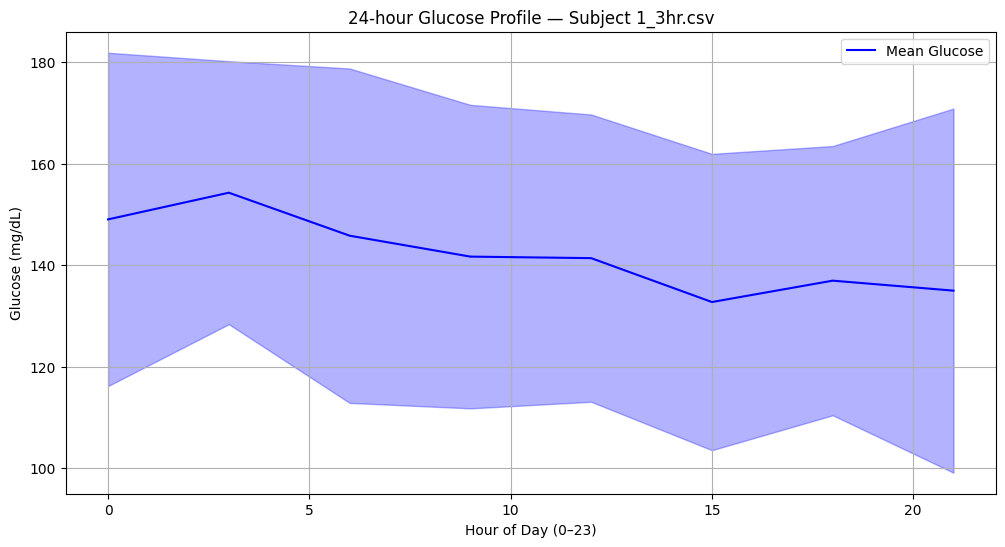

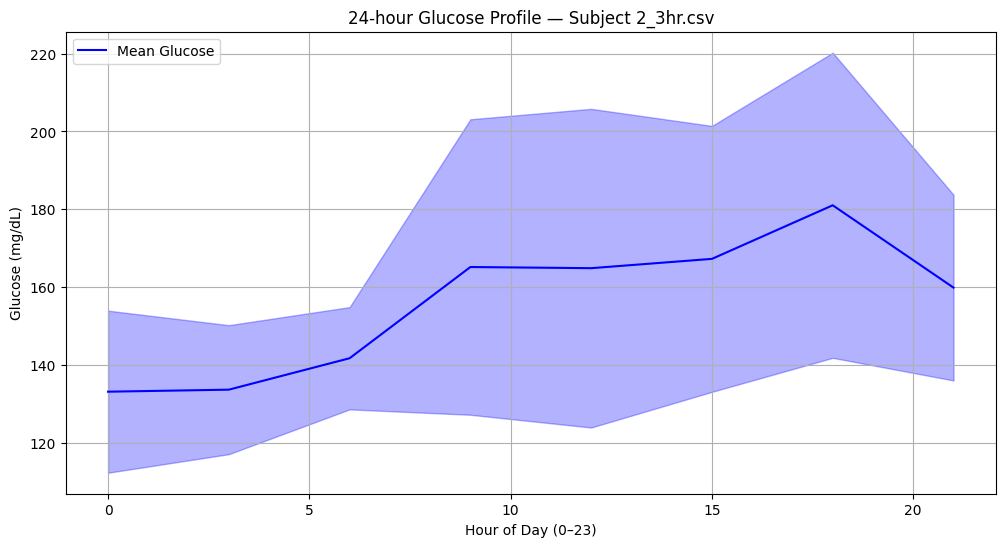

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive

drive.mount('/content/drive')

# Base folder
base_dir = "/content/drive/MyDrive/diabetes/"

# Subjects to analyze
subjects = ["Subject 1_3hr.csv", "Subject 2_3hr.csv"]

def plot_24_hour_profile(file_name):
    path = base_dir + file_name
    df = pd.read_csv(path)

    # Detect columns
    def detect_columns(df):
        dt_col, cgm_col = None, None
        for c in df.columns:
            cl = c.lower()
            if "date" in cl or "time" in cl:
                dt_col = c
            if "cgm" in cl or "glucose" in cl:
                cgm_col = c
        return dt_col, cgm_col

    dt_col, cgm_col = detect_columns(df)

    if dt_col is None or cgm_col is None:
        print(f"❌ Missing required columns in {file_name}")
        return

    # Clean data
    df[dt_col] = pd.to_datetime(df[dt_col], errors='coerce')
    df[cgm_col] = pd.to_numeric(df[cgm_col], errors='coerce')
    df = df.dropna(subset=[dt_col, cgm_col])

    # Extract hour
    df["Hour"] = df[dt_col].dt.hour

    # Compute mean + SD per hour
    hourly_mean = df.groupby("Hour")[cgm_col].mean()
    hourly_std = df.groupby("Hour")[cgm_col].std()

    # Plot
    plt.figure(figsize=(12,6))
    plt.plot(hourly_mean.index, hourly_mean.values, label="Mean Glucose", color="blue")
    plt.fill_between(hourly_mean.index,
                     hourly_mean - hourly_std,
                     hourly_mean + hourly_std,
                     alpha=0.3, color="blue")
    plt.title(f"24-hour Glucose Profile — {file_name}")
    plt.xlabel("Hour of Day (0–23)")
    plt.ylabel("Glucose (mg/dL)")
    plt.grid(True)
    plt.legend()
    plt.show()


# ✅ Generate graphs for Subject 1 and Subject 2
plot_24_hour_profile("Subject 1_3hr.csv")
plot_24_hour_profile("Subject 2_3hr.csv")


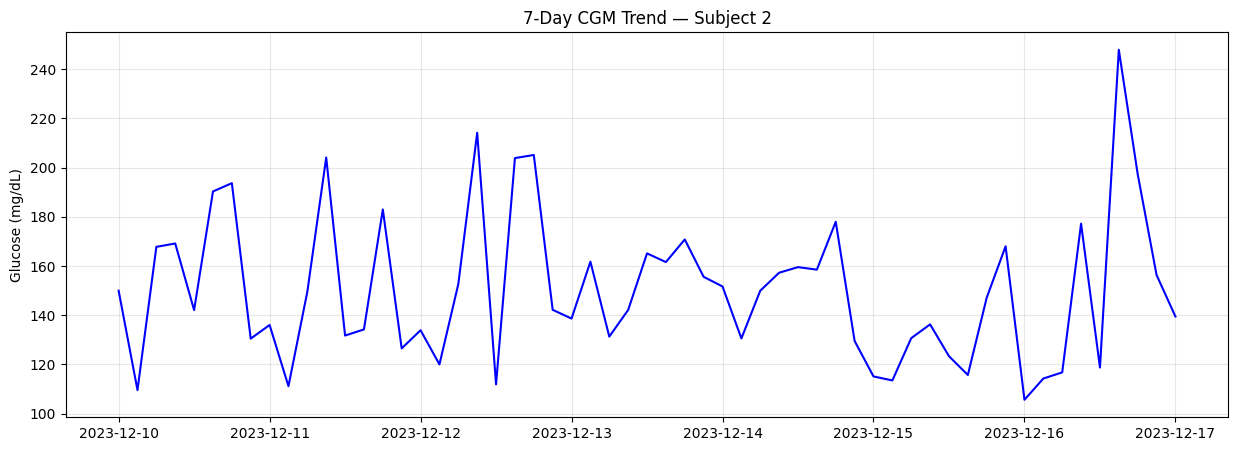

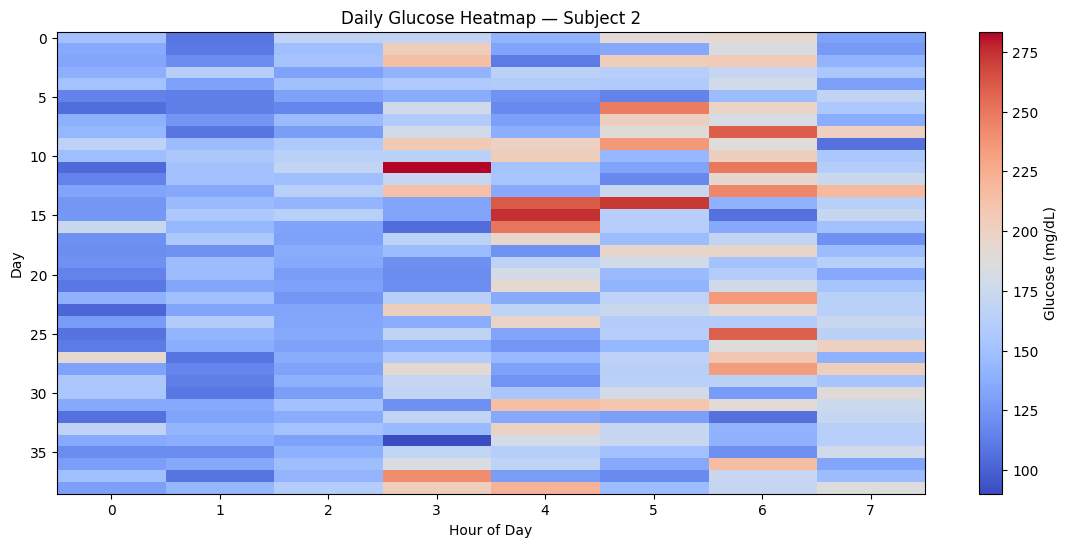

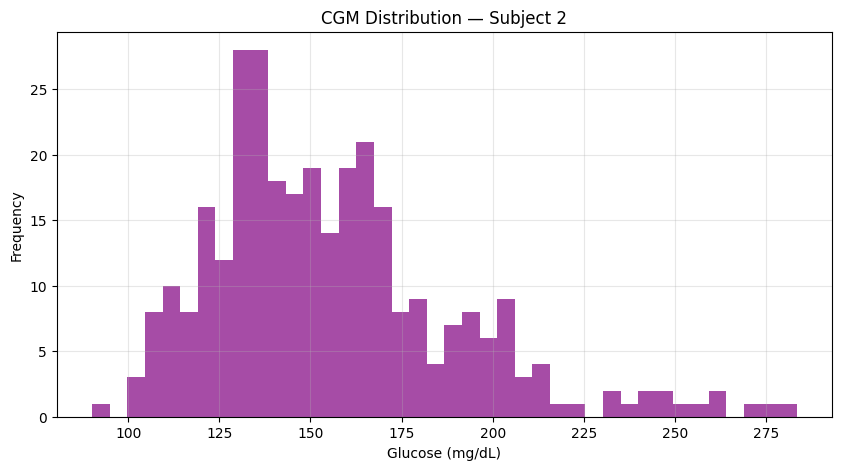

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Helper: detect column names

def detect_cols(df):
    dt_col = None
    cgm_col = None
    for c in df.columns:
        c_low = c.lower()
        if "date" in c_low or "time" in c_low:
            dt_col = c
        if "cgm" in c_low or "glucose" in c_low:
            cgm_col = c
    return dt_col, cgm_col


# Load and clean a subject

def load_subject(path):
    df = pd.read_csv(path)
    df = df.rename(columns=lambda x: x.strip())
    dt_col, cgm_col = detect_cols(df)

    df[dt_col] = pd.to_datetime(df[dt_col], errors='coerce')
    df = df.dropna(subset=[dt_col, cgm_col])
    df = df.sort_values(dt_col)

    return df, dt_col, cgm_col

# 1) Weekly CGM Trend

def plot_weekly_cgm(df, dt_col, cgm_col, subject_name):
    start = df[dt_col].min()
    end = start + pd.Timedelta(days=7)
    week = df[(df[dt_col] >= start) & (df[dt_col] <= end)]

    plt.figure(figsize=(15,5))
    plt.plot(week[dt_col], week[cgm_col], color='blue')
    plt.ylabel("Glucose (mg/dL)")
    plt.title(f"7-Day CGM Trend — {subject_name}")
    plt.grid(alpha=0.3)
    plt.show()


# 2) Daily Hourly CGM Heatmap

def plot_daily_heatmap(df, dt_col, cgm_col, subject_name):
    df['day'] = df[dt_col].dt.date
    df['hour'] = df[dt_col].dt.hour

    pivot = df.pivot_table(values=cgm_col, index='day', columns='hour', aggfunc='mean')

    plt.figure(figsize=(14,6))
    plt.imshow(pivot, aspect='auto', cmap='coolwarm')
    plt.colorbar(label="Glucose (mg/dL)")
    plt.xlabel("Hour of Day")
    plt.ylabel("Day")
    plt.title(f"Daily Glucose Heatmap — {subject_name}")
    plt.show()


# 3) CGM Value Distribution (Histogram)

def plot_cgm_histogram(df, cgm_col, subject_name):
    plt.figure(figsize=(10,5))
    plt.hist(df[cgm_col], bins=40, color='purple', alpha=0.7)
    plt.xlabel("Glucose (mg/dL)")
    plt.ylabel("Frequency")
    plt.title(f"CGM Distribution — {subject_name}")
    plt.grid(alpha=0.3)
    plt.show()


path = "/content/drive/MyDrive/diabetes/Subject 2_3hr.csv"

df, dt_col, cgm_col = load_subject(path)

plot_weekly_cgm(df, dt_col, cgm_col, "Subject 2")
plot_daily_heatmap(df, dt_col, cgm_col, "Subject 2")
plot_cgm_histogram(df, cgm_col, "Subject 2")
